In [43]:
import numpy as np
from scipy import stats
from numba import njit
import numba as nb
import matplotlib.pyplot as plt
import itertools

# Create Indicator and MOMENT Functions (First four moments)

In [44]:
@njit
def indicator_func(x,y):
    if x<y:
        return 1
    else:
        return 0
@njit
def get_ev(timesteps,agent_pdf,time_pdf):
    ev = 0
    for x,px in zip(timesteps,agent_pdf):
        for y,py in zip(timesteps,time_pdf):
            ev+=x*px*py*indicator_func(x,y)
    return ev
@njit(parallel=True)
def get_ev_parallel(timesteps,agent_pdf,time_pdf):
    ev = 0
    for i in nb.prange(len(timesteps)):
        x = timesteps[i]
        px = agent_pdf[i]
        for y,py in zip(timesteps,time_pdf):
            ev+=x*px*py*indicator_func(x,y)
    return ev

@njit
def get_ev2(timesteps,agent_pdf,time_pdf):
    ev = 0
    for x,px in zip(timesteps,agent_pdf):
        for y,py in zip(timesteps,time_pdf):
            ev+=(x**2)*px*py*indicator_func(x,y)
    return ev

@njit
def get_ev3(timesteps,agent_pdf,time_pdf):
    ev = 0
    for x,px in zip(timesteps,agent_pdf):
        for y,py in zip(timesteps,time_pdf):
            ev+=(x**3)*px*py*indicator_func(x,y)
    return ev
@njit
def get_ev4(timesteps,agent_pdf,time_pdf):
    ev = 0
    for x,px in zip(timesteps,agent_pdf):
        for y,py in zip(timesteps,time_pdf):
            ev+=(x**4)*px*py*indicator_func(x,y)
    return ev

@njit
def get_skew(EX,EX2,EX3,sigma):
    ans = (EX3 - 3*EX*(EX2**2) +3*(EX**2)*EX - (EX**3))/(sigma**3)
    return ans
@njit
def get_kurtosis(EX,EX2,EX3,EX4,sigma):
    ans = (EX4 - 4*EX*EX3 + 6*EX**2*sigma**2 + 3*EX**4)/(sigma**4)
    return ans

In [45]:
@njit(parallel=True)
def get_moments(timesteps,agent_pdf,time_pdf):
    m1,m2,m3,m4 = 0,0,0,0
    for i in nb.prange(len(timesteps)):
        x = timesteps[i]
        px = agent_pdf[i]
        for y,py in zip(timesteps,time_pdf):
            if x<y:
                I = 1
            else:
                I = 0 
            m1+=(x**1)*px*py*I
            m2+=(x**2)*px*py*I
            m3+=(x**3)*px*py*I
            m4+=(x**4)*px*py*I
    return [m1,m2,m3,m4]

# Set up PDFs

In [95]:
timesteps = np.arange(0,5000,1) # Timesteps need to go to infinity
agent_mu,agent_sd = 1000,150 
time_mu,time_sd = 700,150
agent_pdf = stats.norm.pdf(timesteps,agent_mu,agent_sd) # Create Agent pdf
time_pdf = stats.norm.pdf(timesteps,time_mu,time_sd) # Create Timing pdf
prob_x_in_A = stats.norm.cdf(0,agent_mu-time_mu,np.sqrt(agent_sd**2+time_sd**2)) # Get probability of any x being in the new distribution for normalization

# Get the First Four Moments 

In [96]:
EX = get_ev(timesteps,agent_pdf,time_pdf) # First moment
EX_norm = EX/prob_x_in_A # Normalize by prob 
print(f'E[X] = {EX_norm}')
EX2 = get_ev2(timesteps,agent_pdf,time_pdf) # Second moment
EX2_norm = get_ev2(timesteps,agent_pdf,time_pdf)/prob_x_in_A
print(f'E[X^2] = {EX2_norm}')

EX3 = get_ev3(timesteps,agent_pdf,time_pdf)
EX3_norm = EX3/prob_x_in_A
print(f'E[X^3] = {EX3_norm}')

EX4 = get_ev4(timesteps,agent_pdf,time_pdf)
EX4_norm = EX4/prob_x_in_A
print(f'E[X^4] = {EX4_norm}')

m1,m2,m3,m4 = get_moments(timesteps,agent_pdf,time_pdf)

E[X] = 798.3434195783188
E[X^2] = 653120.228952613
E[X^3] = 544387740.3981495
E[X^4] = 461778768867.92395


In [97]:
%timeit get_moments(timesteps,agent_pdf,time_pdf) # First moment

10.1 ms ± 70.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [49]:
%timeit get_ev_parallel(timesteps,agent_pdf,time_pdf) # First moment

4.89 ms ± 252 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Vectorized solution (not even sure if it's faster)

1. Get cartesian product of all the timestep pairs
2. Find the pairs where the timestep of the y value is greater than the x value (maybe triangle )

In [50]:
def cartesian_product(*arrays):
    la = len(arrays)
    # dtype = np.result_type(*arrays)
    arr = np.zeros([len(a) for a in arrays] + [la])#, dtype=dtype)
    for i, a in enumerate(np.ix_(*arrays)):
        arr[...,i] = a # [...,i] is like saying [:,i] for 2d array or [:,:,i] for 3d array
    return arr.reshape(-1, la)

In [51]:
a = timesteps
pa = agent_pdf
b = timesteps
pb = time_pdf
s = len(a)
prob_x_in_A = stats.norm.cdf(0,agent_mu-time_mu,np.sqrt(agent_sd**2+time_sd**2)) # Get probability of any x being in the new distribution for normalization
cp_values = cartesian_product(timesteps,timesteps)
mask = (cp_values[:,0]<cp_values[:,1]).reshape(s,s)
total_prob = np.count_nonzero(mask)/len(mask.flatten())
out = np.empty((6000,6000))
EX_norm_check = np.sum(np.outer(pa,pb,out)*(np.tile(a,(6000,1)).T)*mask)/prob_x_in_A
# EX2_norm_check = np.sum(np.outer(pa,pb)*np.outer(a**2,np.ones(len(a)))*mask)/prob_x_in_A
# EX3_norm_check = np.sum(np.outer(pa,pb)*np.outer(a**3,np.ones(len(a)))*mask)/prob_x_in_A
# EX4_norm_check = np.sum(np.outer(pa,pb)*np.outer(a**4,np.ones(len(a)))*mask)/prob_x_in_A
# print(f'E[X] = {EX_norm_check}')
# print(f'E[X^2] = {EX2_norm_check}')
# print(f'E[X^3] = {EX3_norm_check}')
# print(f'E[X^4] = {EX4_norm_check}')

In [52]:
out = np.empty((6000,6000))
%timeit np.sum(np.outer(pa,pb,out)*np.tile(a,(6000,1)).T*mask)/prob_x_in_A

417 ms ± 3.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [87]:
@njit(parallel=True)
def get_outer_products(tiled_timesteps,time_means,agent_pdf,time_pdfs,mask,prob_x_in_A):
    ans = np.empty(len(time_means))
    for i in nb.prange(len(time_means)):
        out = np.empty((6000,6000))
        ans[i] = np.sum(np.outer(agent_pdf,time_pdfs[i,:],out)*tiled_timesteps*mask)/prob_x_in_A
    return ans

In [88]:
new_timesteps = np.arange(-1000,5000,1)
tiled_new_timesteps = np.tile(new_timesteps,(6000,1))
regular_timesteps = np.arange(0,2000,1) # Timing means for the time_pdf
time_means_tiled = np.tile(regular_timesteps,(len(new_timesteps),1)).T
time_pdfs = stats.norm.pdf(new_timesteps,time_means_tiled,100)
get_outer_products(tiled_new_timesteps,regular_timesteps,agent_pdf,time_pdfs,mask,prob_x_in_A)

array([5.76923944e-05, 5.96828359e-05, 6.17398050e-05, ...,
       2.53911003e+04, 2.54038149e+04, 2.54165296e+04])

In [94]:
tiled_agent_pdf = np.tile(agent_pdf,(len(regular_timesteps),1))
# out = np.empty((2000,2000,6000,6000))
np.outer(agent_pdf,time_pdfs)

MemoryError: Unable to allocate 536. GiB for an array with shape (6000, 12000000) and data type float64

In [54]:
out = np.empty((6000,6000))
%timeit np.outer(pa,pb,out)

31.2 ms ± 420 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [55]:
out = np.empty((6000,6000))
%timeit np.outer(pa,pb)

66.6 ms ± 896 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [56]:
%timeit np.tile(a,(6000,1)

SyntaxError: unexpected EOF while parsing (<unknown>, line 1)

In [ ]:
np.outer(a,np.ones(len(a)))

array([[-1000., -1000., -1000., ..., -1000., -1000., -1000.],
       [ -999.,  -999.,  -999., ...,  -999.,  -999.,  -999.],
       [ -998.,  -998.,  -998., ...,  -998.,  -998.,  -998.],
       ...,
       [ 4997.,  4997.,  4997., ...,  4997.,  4997.,  4997.],
       [ 4998.,  4998.,  4998., ...,  4998.,  4998.,  4998.],
       [ 4999.,  4999.,  4999., ...,  4999.,  4999.,  4999.]])

In [ ]:
%timeit 

26 ms ± 288 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
np.count_nonzero(mask)/len(mask.flatten())

0.4999166666666667

In [ ]:
mask_check

array([False,  True,  True, ..., False, False, False])

In [ ]:
@njit
def get_masked_array(cp,mask):
    i=-1
    for x,y in cp:
        i+=1
        if x<y:
            mask[i]=True
    return mask

In [ ]:
def get_ev_new(cp_time,cp_prob):
    ev=0
    for a,b in zip(cp_time,cp_prob):
        x,y = a
        px,py = b
        ev+=x*px*py*indicator_func(x,y)

# Get variance and sd, skew, and kurtosis

#### $Var(X) = E[X^2] + E[X]^2$

#### $Skew(X) = \frac{E[X^3] - 3 \mu \sigma^2 - \mu^3}{\sigma^3}$

In [ ]:
var = EX2_norm - EX_norm**2 # Find the variance
sigma = np.sqrt(var)

skew = get_skew(EX_norm,EX2_norm,EX3_norm,sigma)
kurt = get_kurtosis(EX_norm,EX2_norm,EX3_norm,EX4_norm,sigma)

In [ ]:
agent_skew_pdf = stats.skewnorm.pdf(timesteps,0,EX_norm,sigma)

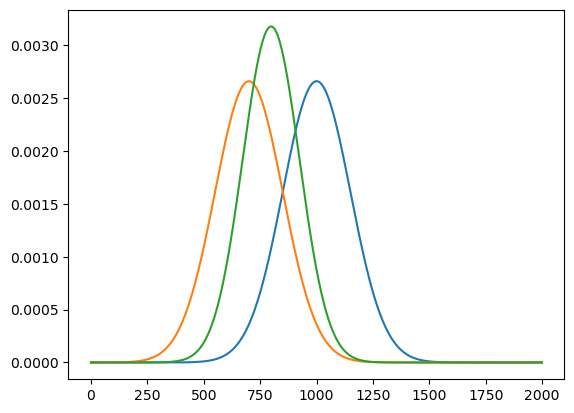

In [ ]:
fig,ax = plt.subplots()
ax.plot(agent_pdf[5000:7000])
ax.plot(time_pdf[5000:7000])
ax.plot(agent_skew_pdf[5000:7000])

# Check Work WITH RVS

In [ ]:
rvs_x = stats.norm.rvs(agent_mu,agent_sd,1000000)
rvs_y = stats.norm.rvs(time_mu,time_sd,1000000)

mask = rvs_y>rvs_x
prob_included = np.count_nonzero(mask)/1000000
np.nanmean(rvs_x[mask])


802.3659345978382

In [ ]:
np.nanstd(rvs_x[mask])

113.93356438107669

In [ ]:
np.nanmean(rvs_x[mask])

802.3659345978382

In [ ]:
stats.skew(rvs_x*mask)

3.260532677510237

In [ ]:
skew

-515977948.8201057

In [ ]:
print(stats.kurtosis(rvs_x[mask]))

0.05383801502124719


In [ ]:
kurt

9.240619737524927

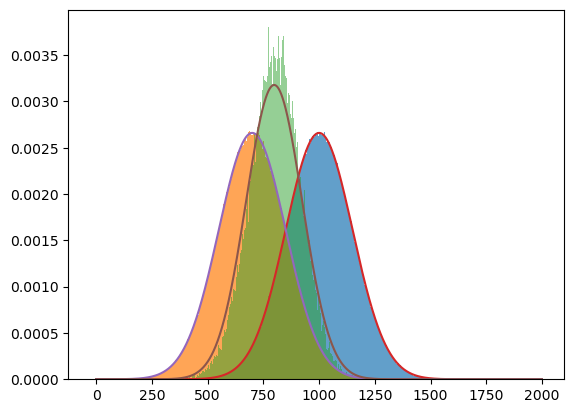

In [ ]:
fig,ax = plt.subplots()
ax.hist(rvs_x,bins = 400,density=True,alpha=0.7)
ax.hist(rvs_y,bins = 400,density=True,alpha=0.7)
ax.hist(rvs_x[mask],bins = 400,density=True,alpha=0.5)
ax.plot(agent_pdf[5000:7000])
ax.plot(time_pdf[5000:7000])
ax.plot(agent_skew_pdf[5000:7000])
plt.show()

In [ ]:
timesteps = np.arange(-1000,2000,1)
timetile = np.tile(timesteps,(len(timesteps),1)).T

a = stats.norm.pdf(timesteps,timetile,100)

In [ ]:
timetile.shape

(3000, 3000)

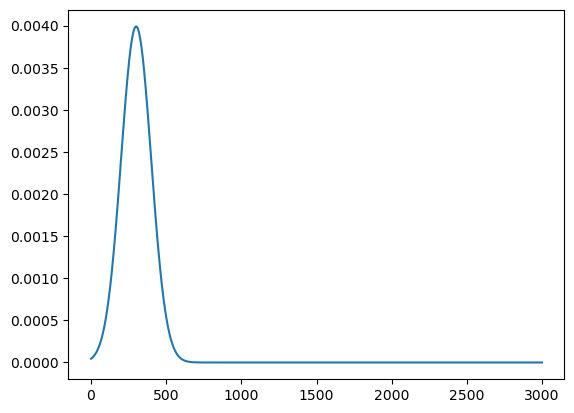

In [ ]:
plt.plot(a[:,300])

# Trying to vectorize (works ish, but can't get faster than just an njit double loop)

In [ ]:
timesteps = np.arange(0,5000,1) # Timesteps need to go to infinity
agent_mu,agent_sd = 1000,150 
time_mu,time_sd = 2000,150
agent_pdf = stats.norm.pdf(timesteps,agent_mu,agent_sd) # Create Agent pdf
time_pdf = stats.norm.pdf(timesteps,time_mu,time_sd) # Create Timing pdf

In [ ]:
a = timesteps
pa = agent_pdf
b = timesteps
pb = time_pdf
s = len(a)
cp_prob = cartesian_product(pa,pb)
cp_amount = cartesian_product(a,b)
cp_amount_reshape = cp_amount.reshape(s,s,2)
cp_prob_reshape = cp_prob.reshape(s,s,2)
mask = np.array(get_masked_array(cp_amount,np.full((s*s,2),False)))
# mask = np.count_nonzero(mask)
mask_reshape = mask.reshape(s,s,2)
cp_amount_masked = cp_amount_reshape*mask_reshape
cp_prob_mult_masked = (cp_prob_reshape[:,:,0]*cp_prob_reshape[:,:,1])*mask_reshape[:,:,0]

np.sum(cp_amount_masked[:,:,0]*cp_prob_mult_masked)/np.sum(cp_prob_mult_masked)

999.9993605604392

In [ ]:
a = timesteps
pa = agent_pdf
b = timesteps
pb = time_pdf
s = len(a)
cp_values = cartesian_product(timesteps,timesteps)
mask = np.array(get_masked_array(cp_values,np.full((s*s,2),False))).reshape(s,s,2)[:,:,0]
np.sum(np.outer(pa,pb)*np.outer(a,np.ones(len(a)))*mask)

999.9981322093093

In [ ]:
np.sum(cp_prob_mult_masked)

0.4990596840274205

In [ ]:
mult_cp = cp_masked[:,0]*cp_masked[:,1]
np.sum(mult_cp)

0.49812290483135335

In [ ]:
a = np.array([1,2,3,4,5])
pa = np.array([0.1,0.2,0.4,0.2,0.1])
b = np.array([3,4,5,6,7])
pb = np.array([0.1,0.2,0.4,0.2,0.1])
s = len(a)
cp_prob = cartesian_product(pa,pb)
cp_amount = cartesian_product(a,b)
cp_amount_reshape = cp_amount.reshape(s,s,2)
cp_prob_reshape = cp_prob.reshape(s,s,2)
mask = np.array(get_masked_array(cp_amount,np.full((s*s,2),False)))
# mask = np.count_nonzero(mask)
mask_reshape = mask.reshape(s,s,2)
cp_amount_masked = cp_amount_reshape*mask_reshape
cp_prob_mult_masked = (cp_prob_reshape[:,:,0]*cp_prob_reshape[:,:,1])*mask_reshape[:,:,0]

np.sum(cp_amount_masked[:,:,0]*cp_prob_mult_masked)/np.sum(cp_prob_mult_masked)

2.7590361445783125

In [ ]:
(cp_prob_reshape[:,:,0]*cp_prob_reshape[:,:,1])*mask_reshape[:,:,0]

array([[0.01, 0.02, 0.04, 0.02, 0.01],
       [0.02, 0.04, 0.08, 0.04, 0.02],
       [0.  , 0.08, 0.16, 0.08, 0.04],
       [0.  , 0.  , 0.08, 0.04, 0.02],
       [0.  , 0.  , 0.  , 0.02, 0.01]])

In [ ]:
np.sum(cp_amount_masked[:,:,0]*pa_tiled*pb_tiled)

2.6200000000000006

In [ ]:
p = np.zeros((len(a),len(b)))
i=-1
for x,px in zip(a,pa):    
    i+=1
    j=-1
    for y,py in zip(b,pb):    
        j+=1
        p[i,j]=px*py*indicator_func(x,y)

In [ ]:
p

array([[0.01, 0.02, 0.04, 0.02, 0.01],
       [0.02, 0.04, 0.08, 0.04, 0.02],
       [0.  , 0.08, 0.16, 0.08, 0.04],
       [0.  , 0.  , 0.08, 0.04, 0.02],
       [0.  , 0.  , 0.  , 0.02, 0.01]])

In [ ]:
ev = 0
for x,px in zip(a,pa):    
    for y,py in zip(b,pb):    
        ev+= x*px*py*indicator_func(x,y)


In [ ]:
ev

2.2900000000000005

In [ ]:
ev/p

2.759036144578313

In [ ]:
print(EX_norm)
get_ev_vec(timesteps,agent_pdf,time_pdf)/prob_x_in_A

798.3434195747286


8900.235584483591